### **Import & Prepare Dataset**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Normalizes data to the [-1, 1] range to match the Tanh activation.
transform_standard = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# DataLoaders for standard/denoising models
train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform_standard),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transform_standard),
    batch_size=128, shuffle=False
)

# Normalizes data to the [0, 1] range to match the Sigmoid activation and BCE Loss.
transform_vae = transforms.Compose([
    transforms.ToTensor()
])

# DataLoaders for the VAE model
vae_train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform_vae),
    batch_size=128, shuffle=True
)
vae_test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transform_vae),
    batch_size=128, shuffle=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


### **Build AutoEncoder**

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh() # Outputs in [-1, 1]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded

### **Training AutoEncoder**

In [3]:
latent_dim = 20
autoencoder = Autoencoder(latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10 # Reduced for quicker demo
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        recon = autoencoder(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Normal AE -> Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Normal AE -> Epoch:1, Loss:0.1158
Normal AE -> Epoch:2, Loss:0.0895
Normal AE -> Epoch:3, Loss:0.0825
Normal AE -> Epoch:4, Loss:0.0687
Normal AE -> Epoch:5, Loss:0.0654
Normal AE -> Epoch:6, Loss:0.0591
Normal AE -> Epoch:7, Loss:0.0577
Normal AE -> Epoch:8, Loss:0.0497
Normal AE -> Epoch:9, Loss:0.0541
Normal AE -> Epoch:10, Loss:0.0482


### **Image Generation by AutoEncoder**

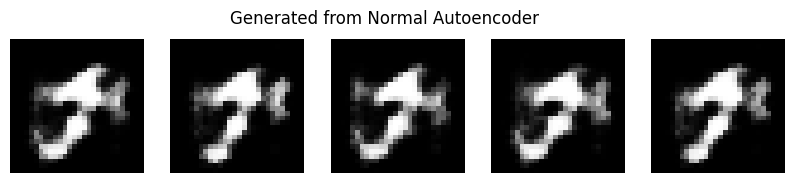

In [19]:
num_images = 5
mean = 5
variance = 1
noise_latent = torch.randn(num_images, latent_dim) * np.sqrt(variance) + mean

with torch.no_grad():
    generated_images = autoencoder.decoder(noise_latent).view(-1, 1, 28, 28)

fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated from Normal Autoencoder')
plt.show()

### **Training Denoising AutoEncoder**

In [5]:
denoising_autoencoder = Autoencoder(latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_autoencoder.parameters(), lr=0.001)

num_epochs = 10 # Reduced for quicker demo
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        noise_amount = 0.5
        noisy_img = img + noise_amount * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, -1., 1.)

        recon = denoising_autoencoder(noisy_img)
        loss = criterion(recon, img) # Loss is against the ORIGINAL image

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Denoising AE -> Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Denoising AE -> Epoch:1, Loss:0.1187
Denoising AE -> Epoch:2, Loss:0.0925
Denoising AE -> Epoch:3, Loss:0.0758
Denoising AE -> Epoch:4, Loss:0.0768
Denoising AE -> Epoch:5, Loss:0.0665
Denoising AE -> Epoch:6, Loss:0.0655
Denoising AE -> Epoch:7, Loss:0.0653
Denoising AE -> Epoch:8, Loss:0.0652
Denoising AE -> Epoch:9, Loss:0.0666
Denoising AE -> Epoch:10, Loss:0.0562


### **Image Generation by Denoising AutoEncoder**

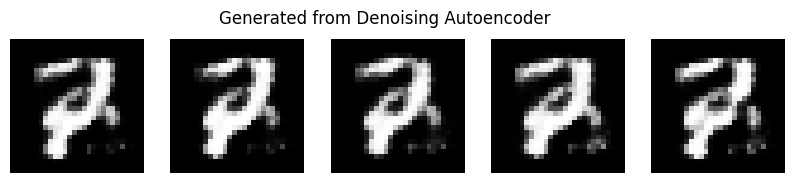

In [20]:
with torch.no_grad():
    generated_images_denoising = denoising_autoencoder.decoder(noise_latent).view(-1, 1, 28, 28)

fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images_denoising[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated from Denoising Autoencoder')
plt.show()

### **Build The Variational Autoencoder (VAE)**

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder_fc1 = nn.Linear(28 * 28, 400)
        self.encoder_fc2_mean = nn.Linear(400, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(400, latent_dim)
        self.decoder_fc1 = nn.Linear(latent_dim, 400)
        self.decoder_fc2 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = torch.relu(self.encoder_fc1(x))
        return self.encoder_fc2_mean(h1), self.encoder_fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(h3)) # Outputs in [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### **Training and Evaluation of VAE**

In [8]:
vae = VAE(latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(vae_train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'VAE -> Epoch: {epoch+1} Avg loss: {train_loss / len(vae_train_loader.dataset):.4f}')

vae.eval()
test_loss = 0
with torch.no_grad():
    for i, (data, _) in enumerate(vae_test_loader):
        recon_batch, mu, logvar = vae(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
test_loss /= len(vae_test_loader.dataset)
print(f'====> VAE Test set loss: {test_loss:.4f}')

VAE -> Epoch: 1 Avg loss: 163.7497
VAE -> Epoch: 2 Avg loss: 121.0711
VAE -> Epoch: 3 Avg loss: 114.3660
VAE -> Epoch: 4 Avg loss: 111.5360
VAE -> Epoch: 5 Avg loss: 109.8553
VAE -> Epoch: 6 Avg loss: 108.7784
VAE -> Epoch: 7 Avg loss: 107.9134
VAE -> Epoch: 8 Avg loss: 107.2838
VAE -> Epoch: 9 Avg loss: 106.8133
VAE -> Epoch: 10 Avg loss: 106.3750
====> VAE Test set loss: 105.6224


### **Image Generation By VAE**

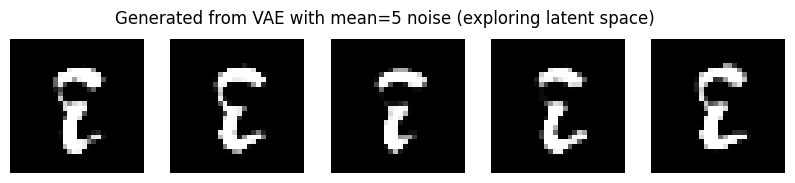

In [27]:
# Note: We are using the same noise_latent variable defined earlier (mean=5, variance=1)
with torch.no_grad():
    generated_images_vae = vae.decode(noise_latent).view(-1, 1, 28, 28)

fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images_vae[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated from VAE with mean=5 noise (exploring latent space)')
plt.show()